## Human Evolution week 1 assignment

Python notebook for calculating bp difference between Modern Human and Neanderthal. The code computes: <br>
-   Counts the number of all 16 possible observations in a 4x4 matrix ("A", "C", "G", "T") for Modern Human and Neanderthal <br>
-   Calculate the total number of base pair differences in windows of 100,000 base pairs and write a table of these values to the output file <br>
-   Create a plot of these window counts along the chromosome using Matplotlib <br>

#### References used
-   Pysam. Python module for reading, manipulating and writing genomic data sets. https://pysam.readthedocs.io/en/latest/index.html <br>
-   Pandas. Python library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language. https://pandas.pydata.org/docs/index.html <br>
-   https://stackoverflow.com/questions/16476924/how-can-i-iterate-over-rows-in-a-pandas-dataframe <br>
-   https://stackoverflow.com/questions/40923165/python-pandas-equivalent-to-r-groupby-mutate <br>
-   https://www.biostars.org/p/418244/ <br>
-   Google search: "filter values in df in python", "data science in python read files", "sum lines dataframe" <br>
-   NumPy: the absolute basics for beginners. https://numpy.org/doc/2.3/user/absolute_beginners.html# <br>

## Load libraries

In [1]:
from pysam import VariantFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read Altai_1000lines.vcf
-   Read vcf file
-   Extract header (column names of vcf file)

In [11]:
vcf_in = VariantFile("/Users/williamlautert/Documents/PhD/Courses_Temple/Topics_Bioinfo/week_3_4/Altai_1000lines.vcf")

# Split the header into lines and get the second to last line (Represent the column names of vcf file)

vcf_header = str(vcf_in.header).split('\n')[-2] 

print(vcf_header)

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	AltaiNea


[W::bcf_hrec_check] Invalid tag name: "1000gALT"


-   Generate a df of `AltaiNea.hg19_1000g.22.mod.vcf.gz`
-   Filter non SNVs
-   Group SNVs by "A", "C", "G", "T" in columns "REF" and "ALT"
-   Count the total number of SNV

In [ ]:
# Define function to filter SNVs
def filter_snvs(file, bases=["A", "C", "G", "T"]):
    return file[file['REF'].isin(bases) & file['ALT'].isin(bases)]

# Read the vcf file into a pandas dataframe, using the extracted header as column names
df = pd.read_table("data/AltaiNea.hg19_1000g.22.mod.vcf.gz", comment='#', names = vcf_header.split('\t'))


# Filter to include only SNVs and then group by REF and ALT columns, counting occurrences of each combination
all_obs_ref_alt = filter_snvs(df).groupby(['REF', 'ALT']).size().reset_index(name='count')

print(all_obs_ref_alt)


/var/folders/8p/r20s7g596gd55mv_6f0_wsqm0000gn/T/ipykernel_26416/4102462498.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table("data/AltaiNea.hg19_1000g.22.mod.vcf.gz", comment='#', names = vcf_header.split('\t'))


   REF ALT  count
0    A   C   3229
1    A   G  11693
2    A   T   3137
3    C   A   3511
4    C   G   3338
5    C   T  12762
6    G   A  12756
7    G   C   3481
8    G   T   3419
9    T   A   3037
10   T   C  11495
11   T   G   3243


### Counts the number of all 16 possible observations 
-   Create a function that generates a 4x4 matrix and fill it with the SNVs observations
-   Print the total number of difference between Modern Human and Neanderthal

In [ ]:
def gen_matrix(row):
    
    # Create a 4x4 matrix with rows and columns as A, C, G, T
    bases = ["A", "C", "G", "T"]
    matrix = pd.DataFrame(np.zeros((4, 4), dtype=int), 
                          index=bases, columns=bases)
    matrix.at[row['REF'], row['ALT']] = row['count']
    
    # Fill the matrix with counts from filtered_all_obs_ref_alt
    matrix.at[row['REF'], row['ALT']] = row['count']

    # Return matrix
    return matrix

# Apply the function to each row of the dataframe and sum the resulting matrices
conts_snp = sum(all_obs_ref_alt.apply(gen_matrix, axis=1))

print(conts_snp)

print("Total bp difference between Modern Human and Neanderthal:", 
      np.sum(conts_snp.values) - np.trace(conts_snp.values))


       A      C      G      T
A      0   3229  11693   3137
C   3511      0   3338  12762
G  12756   3481      0   3419
T   3037  11495   3243      0
Total bp difference between Modern Human and Neanderthal: 75101


### Calculate the total number of base pair differences in windows of 100,000 base pairs and write a table of these values to the output file.

-   Create a function that creates a 4x4 matrix and fill it with the SNVs observations for each genomic(Kb) window
-   Return a matrix with Start, End, Count variables along genomic range. Each row represent a genomic window

In [16]:
def bp_dif_within_window(file, position, window_size):
    # Create lists to store window ranges and counts
    wnd_10kb = []
    wnd_10kb_counts = []

    # Iterate over the genomic range in steps of window_size
    while position < file['POS'].max():
        # Filter the dataframe for the current window
        temp = file[(file['POS'] >= position) & (file['POS'] < position + window_size)]
        
        # Use the filter_snvs function to get SNVs in the current window 
        f_obs_ref_alt = filter_snvs(temp).groupby(['REF', 'ALT']).size().reset_index(name='count')
        # Append the window range to the list
        wnd_10kb.append(f"{position/1e6:.2f}-{(position + window_size)/1e6:.2f}")
        
        # If no SNVs in the window, append 0 to counts list
        if f_obs_ref_alt.empty:
            wnd_10kb_counts.append(0)
        # Calculate the count of base pair differences in the window and append to counts list    
        else:
            matrix_sum = sum(f_obs_ref_alt.apply(gen_matrix, axis=1)) 
            conts_snp = np.sum(matrix_sum.values) - np.trace(matrix_sum.values)

            wnd_10kb_counts.append(conts_snp)
        
        position += window_size
    
    # Convert counts to integers and create a DataFrame
    counts_wnd_10kb_df = [int(x) for x in wnd_10kb_counts]
    
    # Create a DataFrame with window ranges and their corresponding counts
    counts_wnd_10kb_df = pd.DataFrame({
        'Start': [w.split('-')[0] for w in wnd_10kb],
        'End': [w.split('-')[1] for w in wnd_10kb],
        'Count': wnd_10kb_counts
    })
    
    return counts_wnd_10kb_df

-   Implement `bp_dif_within_window` function 
-   Parameters:
    - Start position = start coordinate in Chr 22 
    - Window size: 100.000bp

In [ ]:
# Implement function with start position and window size of 100,000bp
wnd_10kb_df_start = bp_dif_within_window(df, df.POS.min(), 10**5)

print(wnd_10kb_df_start)

# Write the resulting DataFrame to a TSV file
wnd_10kb_df_start.to_csv("output/wnd_100kb_counts.tsv", sep='\t', index=False)


     Start    End  Count
0    16.05  16.15    119
1    16.15  16.25    158
2    16.25  16.35    196
3    16.35  16.45    264
4    16.45  16.55    103
..     ...    ...    ...
347  50.75  50.85    256
348  50.85  50.95    252
349  50.95  51.05    266
350  51.05  51.15    271
351  51.15  51.25    132

[352 rows x 3 columns]


### Create a plot of these window counts along the chromosome using Matplotlib and save the plot as a jpeg or png file

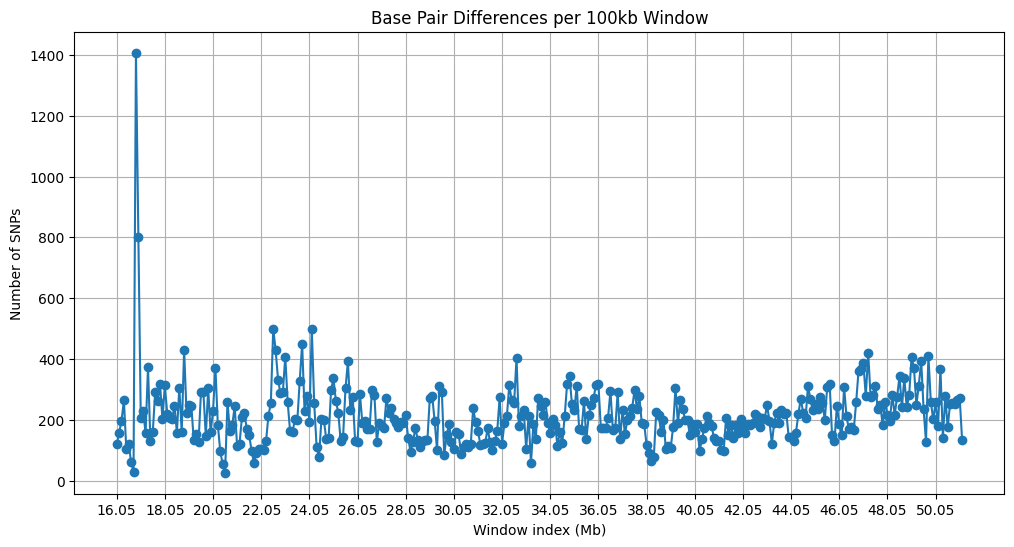

In [20]:
# Set fig size
plt.figure(figsize=(12, 6))

# Plot fig 
plt.plot(wnd_10kb_df_start['Start'], wnd_10kb_df_start['Count'], marker='o')
plt.xlabel("Window index (Mb)")
plt.ylabel("Number of SNPs")
plt.title("Base Pair Differences per 100kb Window")
plt.xticks(ticks=wnd_10kb_df_start['Start'][::20]) # Adjust x-ticks for better readability - Consulted online
plt.grid(True)
plt.savefig("output/bp_differences_per_100kb_window.png")
plt.show()
